--- 1. ĐANG NẠP DỮ LIỆU ---
-> Dữ liệu: 2434 điểm, 2925 cạnh.

--- BẮT ĐẦU CHẠY ĐUA (Eps=300.0, MinPts=40) ---
1. Đang chạy Bản Gốc (Original)...
   -> Hoàn thành trong: 0.3075 giây
2. Đang chạy Bản Cải Tiến (Optimized)...
   -> Hoàn thành trong: 0.2748 giây


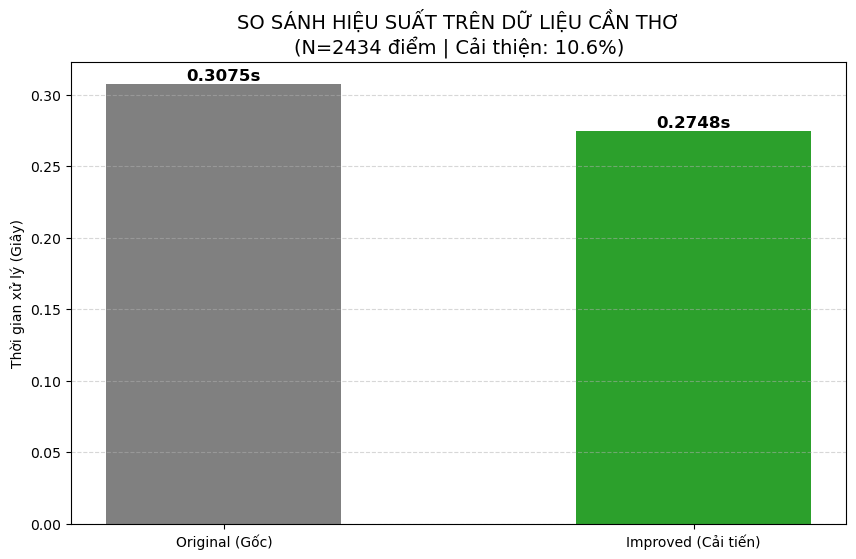


--- KẾT LUẬN ---
✅ Bản cải tiến nhanh hơn 10.63%!
Lý do: Nhờ cắt tỉa đồ thị và lọc bớt các điểm nhiễu yếu ngay từ đầu.


In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import math
import time
import sys

# ==============================================================================
# PHẦN 1: NẠP DỮ LIỆU CẦN THƠ
# ==============================================================================
FILE_PATH = r'D:\GIS_Project\data\6_DSCanhKQ2_CanTho_XoaCon3Cot_XoaDongTrung.txt'

print(f"--- 1. ĐANG NẠP DỮ LIỆU ---")
try:
    try:
        df = pd.read_csv(FILE_PATH, sep='\t')
    except:
        df = pd.read_csv(FILE_PATH, delim_whitespace=True)

    df.columns = df.columns.str.strip()
    if 'IdStar' in df.columns: df.rename(columns={'IdStar': 'IdStart'}, inplace=True)
    
    G = nx.from_pandas_edgelist(df, source='IdStart', target='IdEnd', edge_attr='Length')
    for u, v in G.edges(): G[u][v]['weight'] = G[u][v]['Length']
    
    data_nodes = list(G.nodes())
    print(f"-> Dữ liệu: {len(data_nodes)} điểm, {G.number_of_edges()} cạnh.")

except Exception as e:
    print(f"[LỖI] {e}"); sys.exit()

# ==============================================================================
# PHẦN 2: ĐỊNH NGHĨA HAI ĐỐI THỦ
# ==============================================================================

# --- ĐỐI THỦ A: THUẬT TOÁN GỐC (ORIGINAL) ---
def algo1_original(G, start_node, eps):
    # Dijkstra trên toàn bộ đồ thị
    distances = {start_node: 0}; queue = [(0, start_node)]; nbrs = []
    while queue:
        d, u = heapq.heappop(queue)
        if d > eps: continue
        nbrs.append(u)
        for v in G.neighbors(u):
            new_d = d + G[u][v]['weight']
            if new_d <= eps: # Điều kiện dừng lỏng lẻo hơn
                if new_d < distances.get(v, float('inf')):
                    distances[v] = new_d; heapq.heappush(queue, (new_d, v))
    return nbrs

def run_original(G, points, eps, min_pts):
    # 1. Tính mật độ cho TẤT CẢ điểm (Không lọc)
    neighbors_cache = {}
    ordered_list = []
    for p in points:
        nbrs = algo1_original(G, p, eps)
        neighbors_cache[p] = nbrs
        ordered_list.append((len(nbrs), p))
    
    # 2. Sắp xếp danh sách dài
    ordered_list.sort(key=lambda x: x[0], reverse=True)
    ordered_points = [x[1] for x in ordered_list]
    
    # 3. Gom cụm (Xử lý Nhiễu thủ công)
    labels = {}; cluster_id = 0; NOISE = -1
    for p in ordered_points:
        if p in labels: continue
        if len(neighbors_cache[p]) < min_pts:
            labels[p] = NOISE # Gán nhãn Nhiễu
        else:
            cluster_id += 1; labels[p] = cluster_id
            seeds = list(neighbors_cache[p])
            while seeds:
                q = seeds.pop(0)
                if q in labels:
                    if labels[q] == NOISE: labels[q] = cluster_id # Cứu điểm biên
                else:
                    labels[q] = cluster_id
                    if len(neighbors_cache[q]) >= min_pts: seeds.extend(neighbors_cache[q])
    return labels

# --- ĐỐI THỦ B: THUẬT TOÁN CẢI TIẾN (OPTIMIZED) ---
def run_optimized(G, points, eps, min_pts):
    # 1. Cắt tỉa đồ thị (Pruning)
    valid_edges = [(u,v,d) for u,v,d in G.edges(data=True) if d['weight'] <= eps]
    G_pruned = nx.Graph(); G_pruned.add_nodes_from(G.nodes()); G_pruned.add_edges_from(valid_edges)
    
    # 2. Tính mật độ có lọc Heuristic
    neighbors_cache = {}
    ordered_list = []
    threshold = math.log(len(points)) # Ngưỡng lọc
    
    for p in points:
        # Chạy trên G_pruned
        distances = {p: 0}; queue = [(0, p)]; nbrs = []
        while queue:
            d, u = heapq.heappop(queue)
            if d > eps: continue
            nbrs.append(u)
            for v in G_pruned.neighbors(u):
                new_d = d + G_pruned[u][v]['weight']
                if new_d <= eps: # Điều kiện dừng chặt
                    if new_d < distances.get(v, float('inf')):
                        distances[v] = new_d; heapq.heappush(queue, (new_d, v))
        
        # Lọc ngay lập tức
        if len(nbrs) >= threshold:
            neighbors_cache[p] = nbrs
            ordered_list.append((len(nbrs), p))
            
    ordered_list.sort(key=lambda x: x[0], reverse=True)
    ordered_points = [x[1] for x in ordered_list]
    
    # 3. Gom cụm nhanh (Bỏ qua Noise)
    labels = {}; cluster_id = 0
    for p in ordered_points:
        if p in labels: continue
        if len(neighbors_cache[p]) >= min_pts:
            cluster_id += 1; labels[p] = cluster_id
            seeds = list(neighbors_cache[p])
            while seeds:
                q = seeds.pop(0)
                if q not in labels: # Gán luôn
                    labels[q] = cluster_id
                    if q in neighbors_cache: # Chỉ mở rộng nếu là điểm mạnh
                        if len(neighbors_cache[q]) >= min_pts: seeds.extend(neighbors_cache[q])
    return labels

# ==============================================================================
# PHẦN 3: CUỘC ĐUA TỐC ĐỘ (BENCHMARK)
# ==============================================================================

# Tham số test (Cần Thơ)
EPS_TEST = 300.0
MIN_PTS_TEST = 40

print(f"\n--- BẮT ĐẦU CHẠY ĐUA (Eps={EPS_TEST}, MinPts={MIN_PTS_TEST}) ---")

# 1. Chạy Bản Gốc
print("1. Đang chạy Bản Gốc (Original)...")
t0 = time.time()
labels_orig = run_original(G, data_nodes, EPS_TEST, MIN_PTS_TEST)
t1 = time.time()
time_orig = t1 - t0
print(f"   -> Hoàn thành trong: {time_orig:.4f} giây")

# 2. Chạy Bản Cải Tiến
print("2. Đang chạy Bản Cải Tiến (Optimized)...")
t2 = time.time()
labels_opt = run_optimized(G, data_nodes, EPS_TEST, MIN_PTS_TEST)
t3 = time.time()
time_opt = t3 - t2
print(f"   -> Hoàn thành trong: {time_opt:.4f} giây")

# ==============================================================================
# PHẦN 4: VẼ BIỂU ĐỒ SO SÁNH
# ==============================================================================
improvement = ((time_orig - time_opt) / time_orig) * 100

plt.figure(figsize=(10, 6))
algorithms = ['Original (Gốc)', 'Improved (Cải tiến)']
times = [time_orig, time_opt]
colors = ['#808080', '#2ca02c'] # Xám và Xanh lá

bars = plt.bar(algorithms, times, color=colors, width=0.5)

# Ghi số liệu lên cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}s', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Thời gian xử lý (Giây)')
plt.title(f'SO SÁNH HIỆU SUẤT TRÊN DỮ LIỆU CẦN THƠ\n(N={len(data_nodes)} điểm | Cải thiện: {improvement:.1f}%)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("\n--- KẾT LUẬN ---")
if time_opt < time_orig:
    print(f"✅ Bản cải tiến nhanh hơn {improvement:.2f}%!")
    print("Lý do: Nhờ cắt tỉa đồ thị và lọc bớt các điểm nhiễu yếu ngay từ đầu.")
else:
    print("⚠️ Hai phiên bản ngang nhau (do dữ liệu quá nhỏ hoặc Eps quá lớn).")